# NLP with Gauss 2

In [138]:
import string
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TreebankWordTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import (f1_score, recall_score, precision_score, accuracy_score,
                             confusion_matrix, silhouette_score, davies_bouldin_score)


stop = stopwords.words('english')
stop.extend("""!"#$%&'()*+, -./:;<=>?@[\]^_`{|}~""".split())
sns.set_style("darkgrid")
sns.set_palette("rocket")

In [139]:
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    return wordnet.NOUN

# 1. Spam classifier

In [140]:
df = pd.read_csv("spam.csv", encoding='ISO-8859-1')

In [141]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [142]:
df = (df
      .rename(columns={"v1": "is_spam", "v2": "message"})
      .drop(df.columns[2:], axis=1)
      )

In [143]:
df.head()

,is_spam,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   is_spam  5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [145]:
# unballanced classes
df["is_spam"].value_counts(normalize=True)

ham     0.865937
spam    0.134063
Name: is_spam, dtype: float64

In [146]:
spam = df[df.is_spam == "spam"].message.str.lower().to_list()
not_spam = df[df.is_spam != "spam"].message.str.lower().to_list()

In [147]:
spam_wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=set(STOPWORDS)).generate(" ".join(spam))
not_spam_wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=set(STOPWORDS)).generate(" ".join(not_spam))

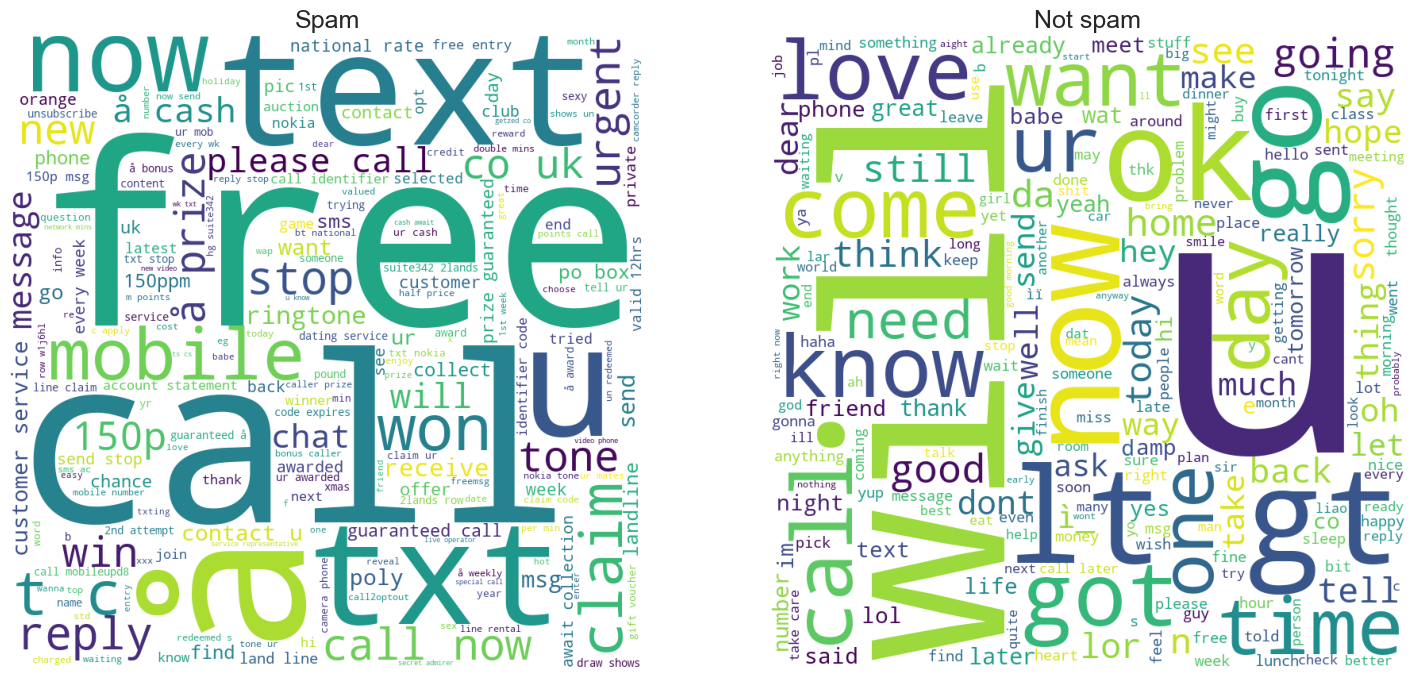

In [148]:
fig, ax = plt.subplots(1, 2, figsize=(18,9), facecolor='w')

ax[0].imshow(spam_wordcloud)
ax[0].axis("off")
ax[0].set_title("Spam", fontsize=18)
ax[1].imshow(not_spam_wordcloud)
ax[1].axis("off")
ax[1].set_title("Not spam", fontsize=18)
plt.show()

In [149]:
df.is_spam = df["is_spam"].map({"ham": 0, "spam": 1})

In [150]:
y = df.is_spam

In [151]:
lemmatizer = WordNetLemmatizer()
tokenizer = TreebankWordTokenizer()

def remove_unecessary(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def process_text(x):
    non_stop = [
        lemmatizer.lemmatize(token, get_wordnet_pos(tag)) 
        for (token, tag) in pos_tag(tokenizer.tokenize(x)) 
        if token not in stop
    ]
    return " ".join(non_stop)


df["message"] = df["message"].str.lower().apply(remove_unecessary).apply(process_text)

In [152]:
df.head()

,is_spam,message
0,0,go jurong point crazy available bugis n great ...
1,0,ok lar joking wif u oni
2,1,free entry 2 wkly comp win fa cup final tkts 2...
3,0,u dun say early hor u c already say
4,0,nah dont think go usf live around though


Many words are incorrectly written. This can be improved with TextBlob package.

## Count Vectorizer and TFIDF

In [153]:
X = TfidfVectorizer().fit_transform(df.message)

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [155]:
clfs = {
    "Logistic": LogisticRegression(),
    "Naive": GaussianNB(),
    "RandomForest": RandomForestClassifier(n_estimators=40),
    "KN": KNeighborsClassifier(n_neighbors=40)
}

In [156]:
dense_X_train = X_train.toarray()
dense_X_test = X_test.toarray()

In [157]:
def fit_predict_and_evaluate(name, clf):
    clf.fit(dense_X_train, y_train)
    predictions = clf.predict(dense_X_test)
    
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    plt.show()
    
    print(f"Classifier: {name}\n")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1}")
    print(20 * "-")

Recall and precision values indicate that there's problem with class balance.

In [158]:
for (name, clf) in clfs.items():
    fit_predict_and_evaluate(name, clf)

Classifier: Logistic

Accuracy: 0.9443946188340807
Precision: 0.9583333333333334
Recall: 0.6133333333333333
F1-score: 0.7479674796747966
--------------------
Classifier: Naive

Accuracy: 0.8654708520179372
Precision: 0.5
Recall: 0.9133333333333333
F1-score: 0.6462264150943396
--------------------
Classifier: RandomForest

Accuracy: 0.9748878923766816
Precision: 1.0
Recall: 0.8133333333333334
F1-score: 0.8970588235294117
--------------------
Classifier: KN

Accuracy: 0.9291479820627803
Precision: 1.0
Recall: 0.47333333333333333
F1-score: 0.6425339366515836
--------------------


# 2. News clustering

In [24]:
from sklearn.datasets import fetch_20newsgroups

categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
]

dataset = fetch_20newsgroups(
    data_home="news",
    remove=("headers", "footers", "quotes"),
    subset="all",
    categories=categories,
    shuffle=True,
    random_state=42,
)

news = dataset.data
labels = dataset.target

In [74]:
vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    stop_words="english",
)

news_tfidf = vectorizer.fit_transform(dataset.data)

In [77]:
clutsters_nums = list(range(2, 7))
inertias = []
silhouettes = []
davies_bouldin = []
for k in clutsters_nums:
    kmeans = KMeans(n_clusters=k).fit(news_tfidf)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(news_tfidf, kmeans.labels_))
    davies_bouldin.append(davies_bouldin_score(news_tfidf.toarray(), kmeans.labels_))

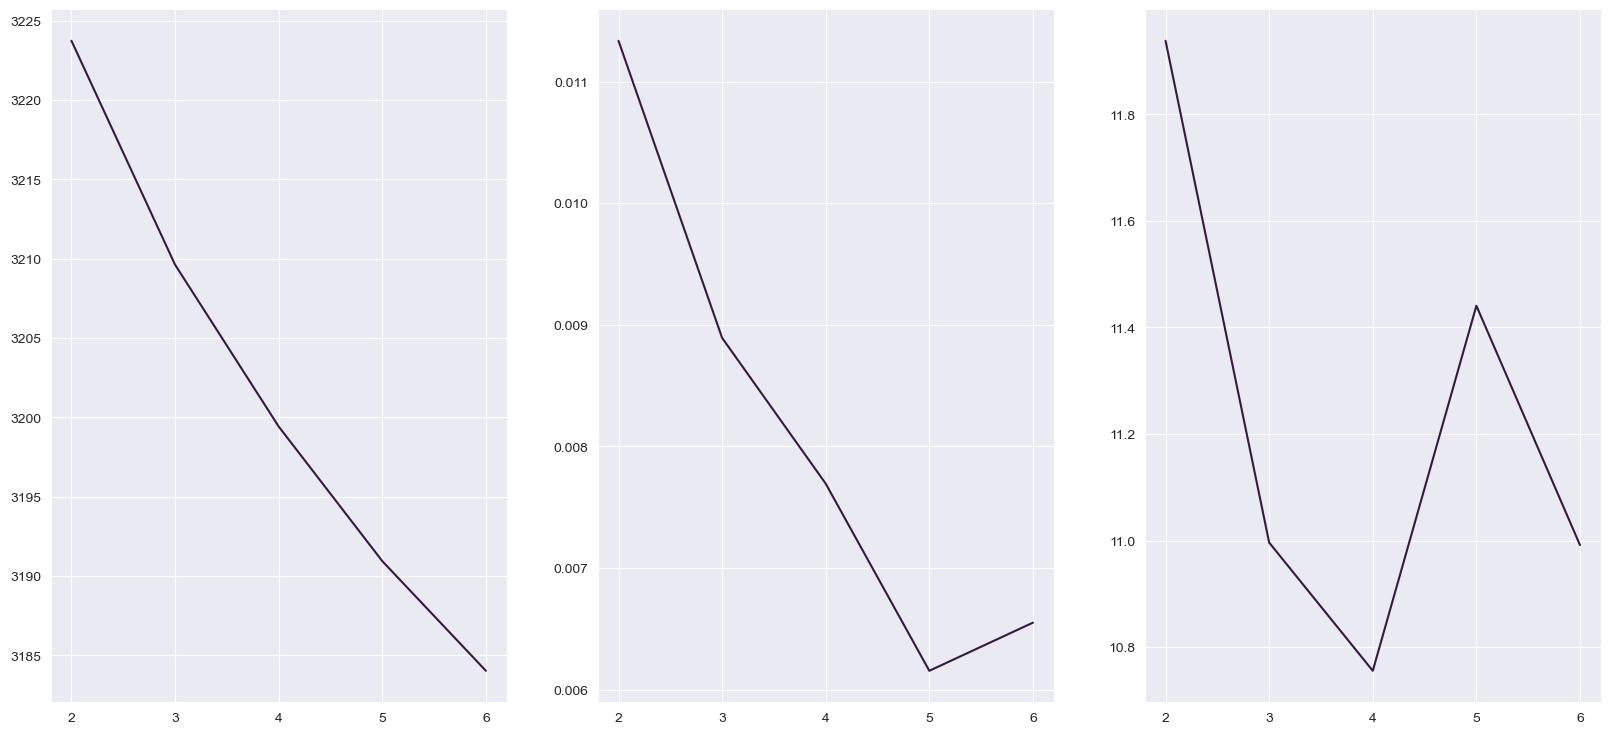

In [84]:
fig, ax = plt.subplots(1, 3, figsize=(20, 9))

sns.lineplot(x=clutsters_nums, y=inertias, ax=ax[0])
sns.lineplot(x=clutsters_nums, y=silhouettes, ax=ax[1])
sns.lineplot(x=clutsters_nums, y=davies_bouldin, ax=ax[2])

for i in range(3):
    ax[i].set_xticks(clutsters_nums, clutsters_nums)
    
plt.show()

We will choose $k=3, 4$.

In [86]:
def pca_plot(data, labels):
    pca = PCA(n_components=2)
    data_after_pca = pca.fit_transform(data.toarray())
    sns.scatterplot(x=data_after_pca[:, 0], y=data_after_pca[:, 1], c=labels, alpha=0.5)
    plt.show()

In [87]:
model = KMeans(n_clusters=3).fit(news_tfidf)

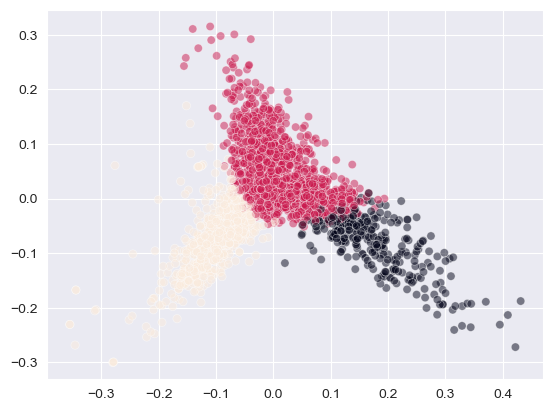

In [88]:
pca_plot(news_tfidf, model.labels_)

In [89]:
texts = np.array(news)

In [90]:
def clusters_wordcloud(model):
    groups = []

    for i in np.unique(model.labels_):
        groups.append(texts[model.labels_ == i])

    for i in groups:
        spam_wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=set(STOPWORDS)).generate(" ".join(i))

        fig, ax = plt.subplots(figsize=(10, 6), facecolor='w')

        ax.imshow(spam_wordcloud)
        ax.axis("off")
        plt.show()

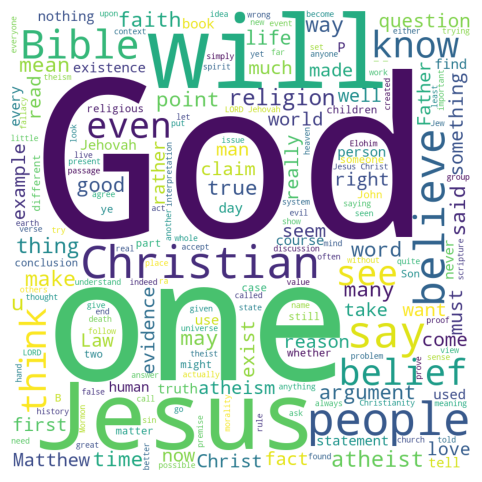

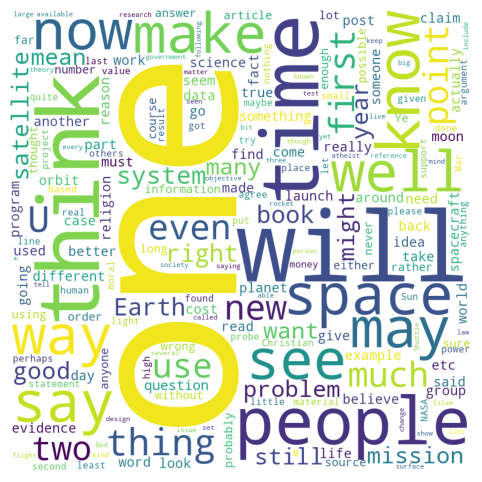

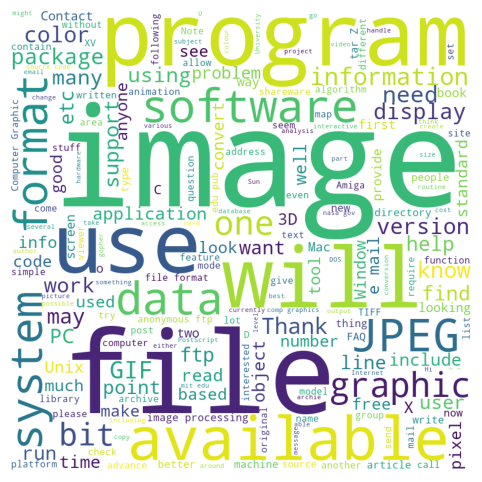

In [91]:
clusters_wordcloud(model)

In [92]:
model_2 = KMeans(n_clusters=4).fit(news_tfidf)

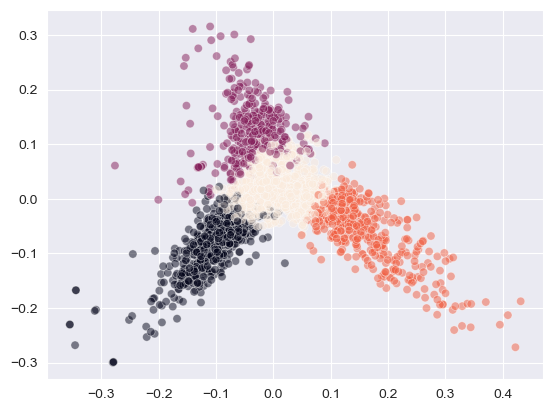

In [94]:
pca_plot(news_tfidf, model_2.labels_)

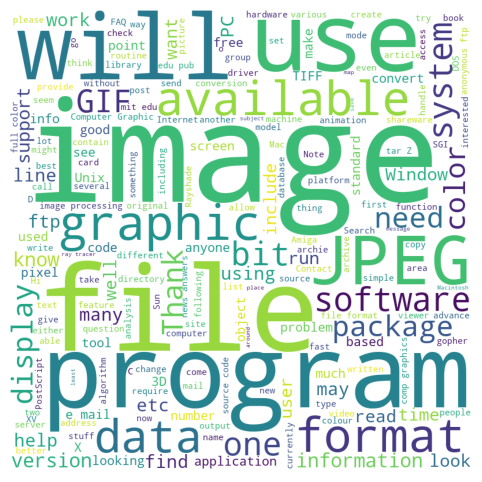

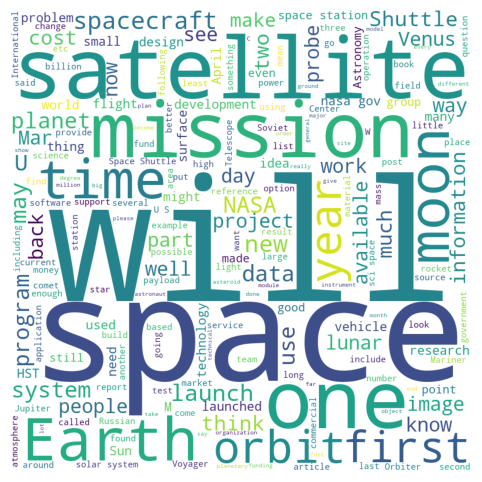

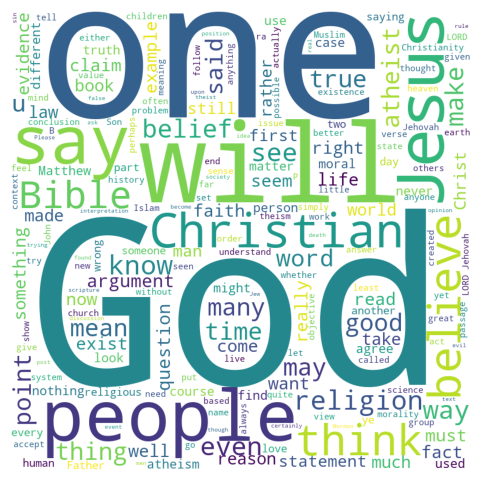

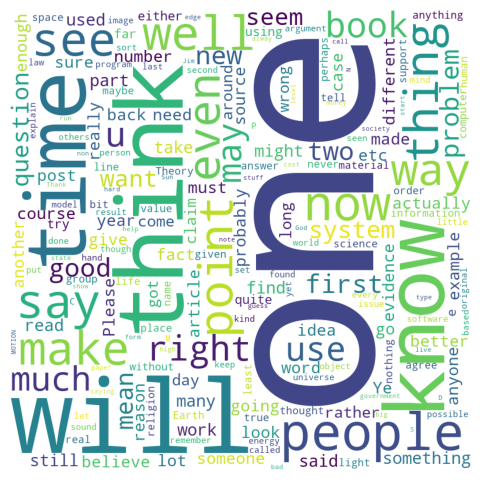

In [93]:
clusters_wordcloud(model_2)